In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-automobile-nse-data/stat_arb_data.csv


In [38]:
import matplotlib.pyplot as plt

In [39]:
prices = pd.read_csv("/kaggle/input/indian-automobile-nse-data/stat_arb_data.csv")

In [40]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1239 entries, 0 to 1238
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1239 non-null   object 
 1   ASHOKLEY.NS    1239 non-null   float64
 2   BAJAJ-AUTO.NS  1239 non-null   float64
 3   EICHERMOT.NS   1239 non-null   float64
 4   HEROMOTOCO.NS  1239 non-null   float64
 5   M&M.NS         1239 non-null   float64
 6   MARUTI.NS      1239 non-null   float64
 7   TVSMOTOR.NS    1239 non-null   float64
dtypes: float64(7), object(1)
memory usage: 77.6+ KB


In [41]:
prices['Date'] = pd.to_datetime(prices['Date'])
prices = prices.set_index(prices['Date'])

In [42]:
prices.index

DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2025-12-22', '2025-12-23', '2025-12-24', '2025-12-25',
               '2025-12-26', '2025-12-29', '2025-12-30', '2025-12-31',
               '2026-01-01', '2026-01-02'],
              dtype='datetime64[ns]', name='Date', length=1239, freq=None)

In [43]:
prices = prices.drop('Date', axis=1)

In [44]:
import itertools

pairs = list(itertools.combinations(prices.columns, 2))
len(pairs)


21

In [45]:
pairs

[('ASHOKLEY.NS', 'BAJAJ-AUTO.NS'),
 ('ASHOKLEY.NS', 'EICHERMOT.NS'),
 ('ASHOKLEY.NS', 'HEROMOTOCO.NS'),
 ('ASHOKLEY.NS', 'M&M.NS'),
 ('ASHOKLEY.NS', 'MARUTI.NS'),
 ('ASHOKLEY.NS', 'TVSMOTOR.NS'),
 ('BAJAJ-AUTO.NS', 'EICHERMOT.NS'),
 ('BAJAJ-AUTO.NS', 'HEROMOTOCO.NS'),
 ('BAJAJ-AUTO.NS', 'M&M.NS'),
 ('BAJAJ-AUTO.NS', 'MARUTI.NS'),
 ('BAJAJ-AUTO.NS', 'TVSMOTOR.NS'),
 ('EICHERMOT.NS', 'HEROMOTOCO.NS'),
 ('EICHERMOT.NS', 'M&M.NS'),
 ('EICHERMOT.NS', 'MARUTI.NS'),
 ('EICHERMOT.NS', 'TVSMOTOR.NS'),
 ('HEROMOTOCO.NS', 'M&M.NS'),
 ('HEROMOTOCO.NS', 'MARUTI.NS'),
 ('HEROMOTOCO.NS', 'TVSMOTOR.NS'),
 ('M&M.NS', 'MARUTI.NS'),
 ('M&M.NS', 'TVSMOTOR.NS'),
 ('MARUTI.NS', 'TVSMOTOR.NS')]

In [46]:
def engle_granger(pair):
    score, pvalue, crit_vals = coint(
        prices[pair[0]],
        prices[pair[1]]
    )
    
    print("Test statistic:", score)
    print("p-value:", pvalue)
    print("Critical values:", crit_vals)

In [47]:
def hedge_ratio(pair):
    X = sm.add_constant(prices[pair[1]])
    model = sm.OLS(prices[pair[0]], X).fit()
    
    beta = model.params[pair[1]]
    alpha = model.params['const']
    
    print("Hedge ratio (beta):", beta)

# Selecting co-integrated pairs

In [48]:
from statsmodels.tsa.stattools import coint
pval_matrix = pd.DataFrame(
    np.ones((len(prices.columns), len(prices.columns))),
    index=prices.columns,
    columns=prices.columns
)

for pair in pairs:
    score, pvalue, crit_vals = coint(prices[pair[0]], prices[pair[1]])
    pval_matrix.loc[pair[0], pair[1]] = pvalue
    pval_matrix.loc[pair[0], pair[1]] = pvalue

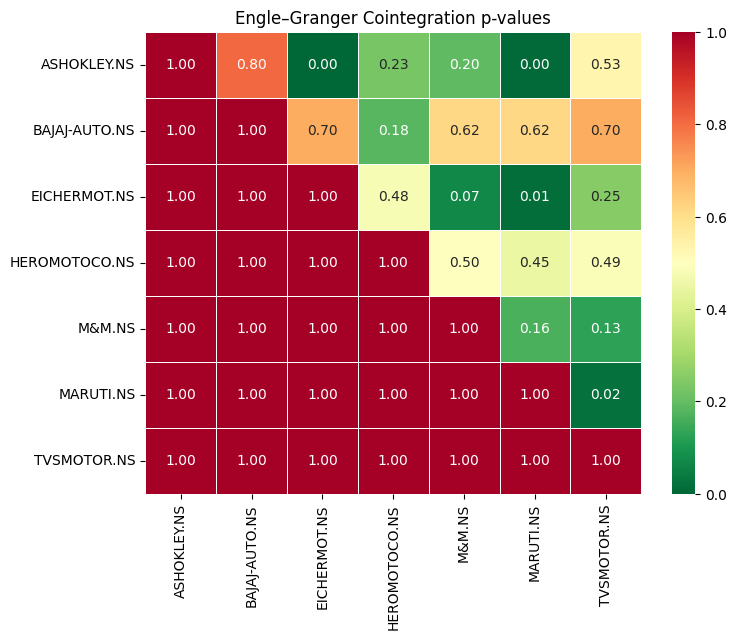

In [49]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(
    pval_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn_r",   # green = low p-value
    vmin=0,
    vmax=1,
    linewidths=0.5
)

plt.title("Engle–Granger Cointegration p-values")
plt.show()

In [50]:
results = []

for pair in pairs:
    score, pvalue, _ = coint(prices[pair[0]], prices[pair[1]])
    
    results.append({
        "asset_1": pair[0],
        "asset_2": pair[1],
        "pvalue": pvalue
    })

results_df = pd.DataFrame(results).sort_values("pvalue")


In [51]:
candidates = results_df[results_df["pvalue"] < 0.05]
print(candidates)

         asset_1       asset_2    pvalue
1    ASHOKLEY.NS  EICHERMOT.NS  0.002100
4    ASHOKLEY.NS     MARUTI.NS  0.004631
13  EICHERMOT.NS     MARUTI.NS  0.012956
20     MARUTI.NS   TVSMOTOR.NS  0.021914


Evidently, from the above, intuitively it can be concluded that there exists a triplet too in ASHOKLEY.NS, EICHERMOT.NS and MARUTI.NS. Needs to be tested though